In [1]:
import numpy as np
from matplotlib import pyplot
from IPython.display import Markdown

First we define some parameters for our system

In [2]:
# mathematica: {{\[Mu]->0.00331511,\[Lambda]->0.005,\[Rho]->1.}}
lamda = 0.005
kappa = 0.25
rho = 0.01
mu = 0.01
mean_s = kappa / lamda
mean_x = mean_s * rho / mu
tau_s = 1/lamda
tau_x = 1/mu * (1 + rho * mu / (lamda * (lamda + rho + mu)))
delta = tau_x/50

Markdown(r"""
We define the following parameters

$\langle s \rangle = {}$

$\langle x \rangle = {}$

$\tau_s = {}$

$\tau_x = {}$

$\rho \Delta = {}$
""".format(mean_s, mean_x, tau_s, tau_x, rho * delta))


We define the following parameters

$\langle s \rangle = 50.0$

$\langle x \rangle = 50.0$

$\tau_s = 200.0$

$\tau_x = 180.0$

$\rho \Delta = 0.036000000000000004$


In [4]:
tau_x

180.0

The analytical rate is defined by $R(S,X)=\frac{\lambda}{2}\left[\sqrt{1+\rho/\lambda}-1\right]$

In [7]:
analytical_rate = lambda rho, lamda: lamda/2 * (np.sqrt(1 + rho/lamda) - 1)
Markdown("$R(S,X) = {}$".format(analytical_rate(rho, lamda)))

$R(S,X) = 0.001830127018922193$

In [3]:
def sigma_ss(rho, mu, lamda, kappa):
    return kappa / lamda

def sigma_xs(rho, mu, lamda, kappa):
    return sigma_ss(rho, mu, lamda, kappa) / (lamda + mu)

def sigma_xx(rho, mu, lamda, kappa):
    return kappa / lamda * rho / mu * (1 + rho / (lamda + mu))

def corr_ss(t, rho, mu, lamda, kappa):
    return kappa / lamda * np.exp(-np.abs(t) * lamda)

def corr_xs_pos(t, rho, mu, lamda, kappa):
    return rho * kappa / lamda / (lamda + mu) * np.exp(-lamda * t)

def corr_sx_pos(t, rho, mu, lamda, kappa):
    a = rho * kappa / lamda / (lamda - mu)
    b1 = (1 + (lamda - mu)/(lamda + mu))*np.exp(-mu * t)
    b2 = - np.exp(-lamda * np.abs(t))
    return a * (b1 + b2)

def corr_xs(t, rho, mu, lamda, kappa):
    return np.where(t >= 0, corr_xs_pos(t, rho, mu, lamda, kappa), corr_sx_pos(-t, rho, mu, lamda, kappa))

def corr_sx(t, rho, mu, lamda, kappa):
    return np.where(t >= 0, corr_sx_pos(t, rho, mu, lamda, kappa), corr_xs_pos(-t, rho, mu, lamda, kappa))

def corr_xx(t, rho, mu, lamda, kappa):
    c1 = np.exp(-mu * np.abs(t)) - np.exp(-lamda * np.abs(t))
    c2 = np.exp(-mu * np.abs(t))
    d1 = rho**2 / (lamda**2 - mu**2) * kappa / lamda
    d2 = (1+rho/(lamda+mu)) * kappa / lamda * rho / mu
    return (d1*c1 + d2*c2)

def corr_z(t, rho, mu, lamda, kappa):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    c_sx = corr_sx(t, rho, mu, lamda, kappa)
    c_xs = corr_xs(t, rho, mu, lamda, kappa)
    c_xx = corr_xx(t, rho, mu, lamda, kappa)
    return np.block([[c_ss, c_xs], [c_sx, c_xx]])

def time_matrix(N, delta_t):
    time_stamps = np.expand_dims(np.linspace(0, (N-1)*delta_t, N), 0)
    return time_stamps - time_stamps.T

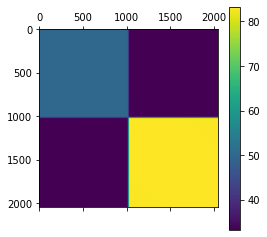

In [4]:
t = time_matrix(1024, 0.0006103515625)
c_ss = corr_ss(t, rho, mu, lamda, kappa)
c_sx = corr_sx(t, rho, mu, lamda, kappa)
c_xs = corr_xs(t, rho, mu, lamda, kappa)
c_xx = corr_xx(t, rho, mu, lamda, kappa)
c_z = corr_z(t, rho, mu, lamda, kappa)
pyplot.matshow(c_z, interpolation='bicubic')
pyplot.colorbar()

In [6]:
# from https://blogs.sas.com/content/iml/2012/10/31/compute-the-log-determinant-of-a-matrix.html
def logdet_symmetric(matrix):
    lower_triangular = np.linalg.cholesky(matrix)
    return 2 * np.sum(np.log(np.diag(lower_triangular)))

In [7]:
def mutual_information_from_matrix(t, rho, mu, lamda, kappa):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    c_xx = corr_xx(t, rho, mu, lamda, kappa)
    z = corr_z(t, rho, mu,  lamda, kappa)
    
    det_c_ss = logdet_symmetric(c_ss)
    det_c_xx = logdet_symmetric(c_xx)    
    det_z = logdet_symmetric(z)
    
    return 0.5 * (det_c_ss + det_c_xx - det_z)

def conditional_entropy_from_matrix(t, rho, mu, lamda, kappa):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    z = corr_z(t, rho, mu,  lamda, kappa)
    
    det_c_ss = logdet_symmetric(c_ss)
    n = c_ss.shape[0]
    det_z = logdet_symmetric(z)
        
    return 0.5 * (det_z - det_c_ss + n*np.log(2*np.pi*np.e))

In [8]:
def mutual_information_(N, delta_t, rho, mu, lamda, kappa):
    t = time_matrix(N, delta_t)
    return mutual_information_from_matrix(t, rho, mu, lamda, kappa)

def conditional_entropy_(N, delta_t, rho, mu, lamda, kappa):
    t = time_matrix(N, delta_t)
    return conditional_entropy_from_matrix(t, rho, mu, lamda, kappa)

mutual_information = np.vectorize(mutual_information_)
conditional_entropy = np.vectorize(conditional_entropy_)

In [9]:
# mathematica: {{\[Mu]->0.00331511,\[Lambda]->0.005,\[Rho]->1.}}
# lamda = 0.005
# kappa = lamda*40
# rho = 1.0
# mu = 0.00331511
# mean_s = kappa / lamda
# mean_x = mean_s * rho / mu
# tau_s = 1/lamda
# tau_x = 1/mu * (1 + rho * mu / (lamda * (lamda + rho + mu)))
# delta = tau_x/50.0

# N = 2**np.arange(0,12)
# pyplot.scatter(N, mutual_information(N, delta, rho, mu, lamda, kappa));
# pyplot.plot(N, analytical_rate(rho, lamda) * N * delta)
# pyplot.xscale('log')
# pyplot.yscale('log')
# pyplot.xlabel('$N$')
# N

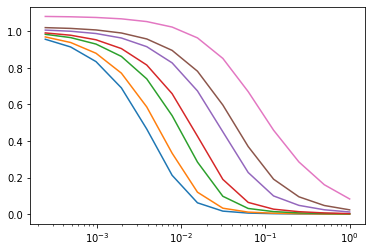

In [99]:
T = 20

N = 2**np.arange(0,13)
delta_arr = T/N

for lamda in [15,10,5,3,1,0.5,0.1]:
    rho = 15
    mu = 1.5
    kappa = lamda
    pyplot.plot(delta_arr / T, mutual_information(N, delta_arr, rho, mu, lamda, kappa) / (T * analytical_rate(rho, lamda)))
pyplot.xscale('log')

In [100]:
analytical_rate(rho, lamda)

0.5644102863722255

# Simulation values

In [9]:
from pathlib import Path
sim_result= np.load(Path.home() / 'testrun' / 'mutual_information.npz')

In [10]:
sim_l = sim_result['trajectory_length'][0]
sim_ce = np.mean(sim_result['conditional_entropy'], axis=0)
sim_l, sim_ce

(array([9.9999998e-03, 1.0023057e-02, 1.0046167e-02, ..., 9.9540448e+02,
        9.9769958e+02, 1.0000000e+03], dtype=float32),
 array([   6.8570583 ,    6.8570583 ,    6.8570583 , ..., 1690.98030505,
        1694.89602494, 1698.83581262]))

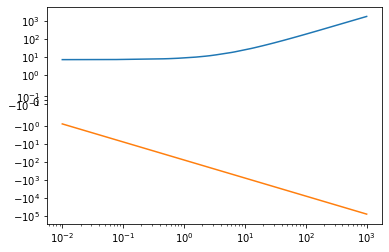

In [11]:
pyplot.plot(sim_l, sim_ce)
pyplot.plot(np.geomspace(1e-2,1e3,1000),  - 79.82 * np.geomspace(1e-2,1e3,1000))
pyplot.yscale('symlog', linthreshy=0.5)
pyplot.xscale('log')

In [36]:
# applied to sim
delta = np.array([[0.0005], [0.001], [0.005], [0.025], [0.035]])
T = np.geomspace(delta[:,0] * 2**4, delta[:,0] * 2**12, 8).T
N = (T / delta).astype(np.int32)

tau_s, tau_x

(200.0, 180.0)

In [33]:
num_l = N * delta
num_ce = conditional_entropy(N, delta, rho, mu, lamda, kappa)

In [34]:
num_l, num_ce, delta

(array([[8.00000e-03, 1.75000e-02, 3.90000e-02, 8.60000e-02, 1.90000e-01,
         4.20000e-01, 9.27000e-01, 2.04800e+00],
        [1.60000e-02, 3.50000e-02, 7.80000e-02, 1.72000e-01, 3.80000e-01,
         8.40000e-01, 1.85400e+00, 4.09600e+00],
        [7.50000e-02, 1.75000e-01, 3.90000e-01, 8.60000e-01, 1.90000e+00,
         4.20000e+00, 9.27000e+00, 2.04800e+01],
        [4.00000e-01, 8.75000e-01, 1.95000e+00, 4.30000e+00, 9.50000e+00,
         2.10000e+01, 4.63500e+01, 1.02400e+02],
        [5.60000e-01, 1.22500e+00, 2.73000e+00, 6.02000e+00, 1.33000e+01,
         2.94000e+01, 6.48900e+01, 1.43325e+02]]),
 array([[-3.22474426e+01, -7.74962313e+01, -1.79901385e+02,
         -4.03763813e+02, -8.99118974e+02, -1.99461596e+03,
         -4.40947237e+03, -9.74882944e+03],
        [-2.70488762e+01, -6.57128142e+01, -1.53215411e+02,
         -3.44500157e+02, -7.67768531e+02, -1.70384282e+03,
         -3.76727614e+03, -8.32962083e+03],
        [-1.37481467e+01, -3.83530497e+01, -9.12535912e

In [12]:
delta = np.array([0.2])
T = np.geomspace(delta[0] * 2**4, delta[0] * 2**12, 15).T
N = (T / delta).astype(np.int32)

T, mutual_information(N, delta, rho, mu, lamda, kappa)

(array([  3.2       ,   4.75518173,   7.06617289,  10.50029256,
         15.60337477,  23.18652581,  34.45504493,  51.2       ,
         76.0829076 , 113.0587662 , 168.00468091, 249.65399638,
        370.98441288, 551.2807189 , 819.2       ]),
 array([0.16057347, 0.16313811, 0.16753439, 0.17376199, 0.18328551,
        0.19683625, 0.21770779, 0.24809272, 0.29384163, 0.36153363,
        0.46213797, 0.61138198, 0.83304402, 1.1629737 , 1.65274695]))

(200.0, 180.0, array([[0.0005],
        [0.001 ],
        [0.005 ],
        [0.025 ],
        [0.035 ]]))

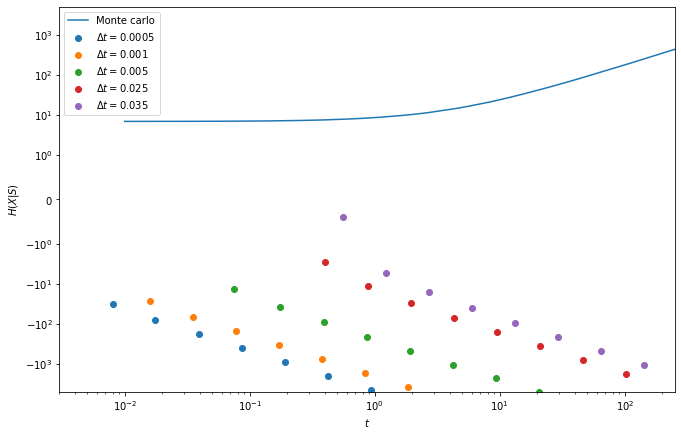

In [16]:
for i, dt in enumerate(delta[:,0]):
    pyplot.scatter(num_l[i], num_ce[i], label=f"$\Delta t = {dt}$");

pyplot.xlabel('$t$')

pyplot.plot(sim_l, sim_ce, label='Monte carlo')

pyplot.xlim(left=3e-3, right=250)
pyplot.xscale('log')
pyplot.yscale('symlog', linthreshy=1)
pyplot.ylim(-5000, 5000)
pyplot.legend()
pyplot.ylabel('$H(X|S)$')
pyplot.gcf().set_size_inches(28/2.54, 18/2.54)
#pyplot.savefig('H(X|S).pdf')
tau_s, tau_x, delta

In [14]:
1000/2**15

array([2.44140625e-06, 5.55626447e-06, 1.26452019e-05, 2.87785311e-05,
       6.54955028e-05, 1.49057673e-04, 3.39232298e-04, 7.72040444e-04,
       1.75704510e-03, 3.99876393e-03, 9.10057061e-03, 2.07114965e-02,
       4.71361750e-02, 1.07274672e-01, 2.44140625e-01])

In [11]:
np.mean(sim_result['mutual_information'], axis=0)

array([0.02795804, 0.027947  , 0.027947  , ..., 1.87747799, 1.87922936,
       1.8806545 ])

In [3]:
file = np.load('/home/ipausers/reinhardt/test_signal.npz')
cd = file['conditional_distribution']
t = file['timestamps']
c = file['components']

In [22]:
np.diff(t[6]).var()

3.9304326

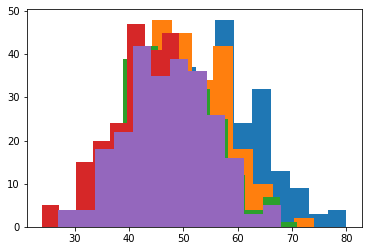

In [41]:
for i in range(5):
    pyplot.hist(cd[i], bins='auto', histtype='stepfilled')

In [25]:
cd.shape

(500, 250, 1)

In [26]:
cd[0]

array([[53.],
       [59.],
       [43.],
       [57.],
       [58.],
       [59.],
       [67.],
       [53.],
       [58.],
       [50.],
       [65.],
       [66.],
       [45.],
       [53.],
       [58.],
       [43.],
       [58.],
       [64.],
       [68.],
       [55.],
       [50.],
       [47.],
       [78.],
       [75.],
       [72.],
       [53.],
       [54.],
       [41.],
       [72.],
       [54.],
       [43.],
       [65.],
       [55.],
       [56.],
       [59.],
       [45.],
       [56.],
       [73.],
       [67.],
       [75.],
       [48.],
       [59.],
       [53.],
       [50.],
       [65.],
       [65.],
       [57.],
       [69.],
       [61.],
       [46.],
       [60.],
       [61.],
       [63.],
       [57.],
       [56.],
       [66.],
       [54.],
       [51.],
       [52.],
       [52.],
       [63.],
       [55.],
       [60.],
       [58.],
       [58.],
       [57.],
       [70.],
       [54.],
       [50.],
       [63.],
       [55.],
      